In [6]:
import pandas as pd
from polarization_estimator import ModelPolarization
from tqdm import trange
import gc
from matplotlib import pyplot as plt
import numpy as np
import json
from statsmodels.graphics.tsaplots import plot_acf
import collections
import pickle
import itertools
import os
import random

## Things to consider:
- treatment of zeros produced when calculating leave-out estimators
- how should be the randomization performed - randomize globally or for at each iteration (i.e. for each time *t*). For now, globally
- why on Earth is the estimator for the population biased upwards

### Run model

In [2]:
import warnings
warnings.filterwarnings('ignore')
def run_models():
    
    
    random.seed(1234)
    #get randomized ids
    gov = pickle.load(open("data/sample/gov_ids.pickle","rb"))[:5000]
    opp = pickle.load(open("data/sample/opp_ids.pickle","rb"))[:5000]
    allids = gov + opp
    shuffled = dict()
    while allids:
        shuffled[allids.pop(random.randint(0,len(allids)-1))] = "gov"
        shuffled[allids.pop(random.randint(0,len(allids)-1))] = "opp"
    
    
    template = {"true":{"plugin":[], "leaveout":[]},
              "random":{"plugin":[], "leaveout":[]}}
    results = collections.defaultdict(lambda: template)
    date = pd.Period('2020-02-22', 'D') 
    
    for _ in trange(65):
        date += 1
        datestr = date.strftime("%Y_%m_%d")
        
        
        path = "data/clean/gov_tweets_" + datestr + ".csv"
        gov_data = pd.read_csv(path, header = 0, index_col = False, dtype = str)
        gov_data["source"] = "government"
        gov_data = gov_data.loc[gov_data.created_at.notna()]
        gov_data = gov_data.drop(columns = ["index"])
        
        
        path = "data/clean/opp_tweets_" + datestr + ".csv"
        opp_data = pd.read_csv(path, header = 0, index_col = False, dtype = str)
        opp_data["source"] = "opposition"
        opp_data = opp_data.loc[opp_data.created_at.notna()]
        opp_data = opp_data.drop(columns = ["index"])

        #merge the datasets
        tweet_data = pd.concat([gov_data, opp_data], axis = 0)
        del(gov_data)
        del(opp_data)
        gc.collect()
        
        #drop any problematic values
        tweet_data.dropna(subset = ["source","preprocessed"], inplace = True)
        
        
        
        
        #get party, user id and text
        parties = tweet_data["source"].tolist()
        users = tweet_data["user-id_str"].tolist()
        tweets = tweet_data["preprocessed"].tolist()
        
        #get randomized users
        random_parties = [shuffled[str(user)] for user in users]
        
        #TRUE ESTIMATES
        model = ModelPolarization(parties, users, tweets)
        results[datestr]["true"]["plugin"].append(model.plug_in(confidence_interval = 100))
        results[datestr]["true"]["leaveout"].append(model.leave_out(confidence_interval = 100))
        
        
        #RANDOMIZED ESTIMATES
        model = ModelPolarization(random_parties, users, tweets)
        results[datestr]["random"]["plugin"].append(model.plug_in(confidence_interval = 100))
        results[datestr]["random"]["leaveout"].append(model.leave_out(confidence_interval = 100))
        
    return results

In [7]:
if os.path.isfile("analysis/polarization_results.json"):
    results = json.load(open("analysis/polarization_results.json","r"))
else:
    results = run_models()
    json.dump(results, open("analysis/polarization_results.json", "w"))
os.system("shutdown")

 42%|████▏     | 27/65 [1:09:59<1:38:29, 155.52s/it]


KeyError: 'nan'

\begin{equation}
\hat{\pi}_{t}^{LO} = \frac{1}{2} \frac{1}{|R_{t}|} \sum_{i \in R_{t}} \hat{q}_{i,t}  \cdot \hat{p}_{-i,t} +  \frac{1}{2} \frac{1}{|D_{t}|} \sum_{i \in D_{t}} \hat{q}_{i,t}  \cdot (1 - \hat{p}_{-i,t})\\
\end{equation}


$\hat{p}_{-i,t} = \hat{q}_{-i,t}^{R} / (\hat{q}_{-i,t}^{R} + \hat{q}_{-,it}^{D})$ is the probability of an observer with a neutral prior assigning a speaker to government based only on a given phrase



$\hat{q}_{i,t} = c_{i,t} / m_{i,t}$ are the phrase frequencies for speaker $i$ at time $t$ 




In [18]:
date = results["date"]
estimate = [elem["point"] for elem in results["leaveout"]]
upper = [elem["upper"] for elem in results["leaveout"]]
lower = [elem["lower"] for elem in results["leaveout"]]

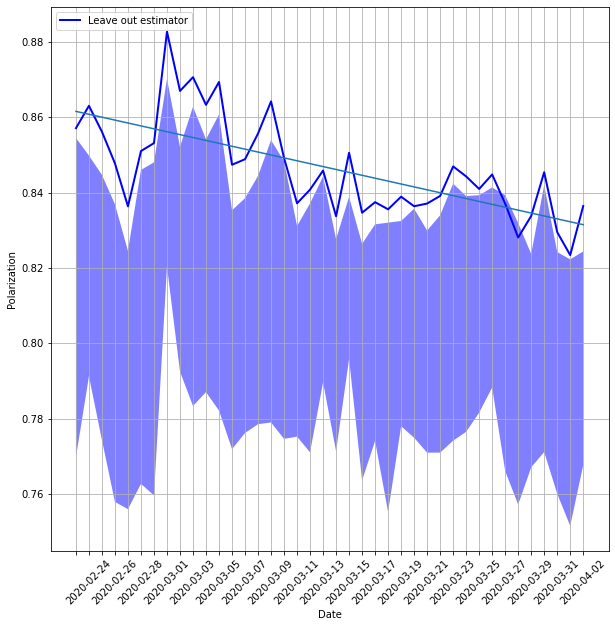

In [20]:
fig, ax = plt.subplots(1,figsize = (10,10))
ax.plot(date, estimate, lw=2, label='Leave out estimator', color='blue')
ax.fill_between(date, upper, lower, facecolor='blue', alpha=0.5)
ax.plot(np.unique(range(len(date))), np.poly1d(np.polyfit(range(len(date)), estimate, 1))(np.unique(range(len(date)))))
ax.legend(loc='upper left')
ax.xaxis.set_tick_params(rotation=45)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
ax.set_xlabel('Date')
ax.set_ylabel('Polarization')
ax.grid()

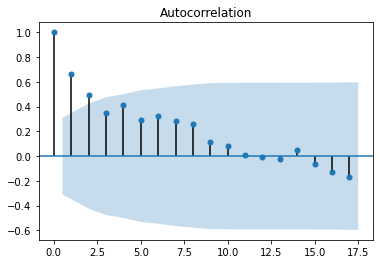

In [32]:
plot_acf(np.array(estimate))
plt.show()